# HW6 Coding - Chatbot

In this assignment, we will use Seq2Seq with Attention to implement a simple generative chatbot. The outline of this notebook is very similar to HW5. The dataset consists of dialogues from the TV show Friends. Dialogues were scraped from [here](https://www.livesinabox.com/friends/scripts.shtml). Due to the noisy nature of the dataset, your models may not learn too well and will require some hyperparameter tuning. However, please note that a very-well tuned model is not the goal of this assignment. The goal is to experiment with different settings and provide analysis in your write-up. Furthermore, we will include checkpoints on Gradescope so you can check your model and dataloader implementations.

In [1]:
# install requirements
!pip install -r requirements.txt

You should consider upgrading via the '/home/andre/miniconda3/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# Imports
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score
import pandas as pd
import time
import numpy as np
import math
from tqdm import tqdm
tqdm.pandas()

# try %matplotlib notebook (if following doesn't work)
%matplotlib inline
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dataset import *
from model import *

# Read and Preprocess *Friends* Scripts


In [5]:
data_df = pd.read_pickle('friends_subtitles.pkl')

Look at the data

In [6]:
print(data_df.shape)
data_df.sample(5)

(76114, 4)


,episode,title,character,dialogue
72124,1008,The One With The Late Thanksgiving,monica,"[no, !, everything, 's, cold, ., the, turkey, ..."
15357,214,The One With The Prom Video,phoebe,"[c'mon, you, guys, ., it, 's, a, known, fact, ..."
25898,315,The One Where Ross and Rachel Take A Break,ross,"[come, on, rach, ,, you, don, ’, t, have, what..."
18554,223,The One With The Chicken Pox,richard,"[no, that, 's, not, true, ., that, is, not, tr..."
62849,914,The One With The Blind Dates,ross,"[what, 's, -, what, 's, going, on, ?]"


In [7]:
# dialogue length distribution
token_lens = data_df.dialogue.progress_apply(lambda x: len(x))
token_lens.describe(percentiles=[0.5, 0.75, 0.90])

100%|██████████| 76114/76114 [00:00<00:00, 877032.95it/s]


count    76114.000000
mean        14.003784
std         15.896689
min          0.000000
50%         10.000000
75%         18.000000
90%         30.000000
max       1157.000000
Name: dialogue, dtype: float64

In [8]:
len_vcs = (token_lens < 20).value_counts()
print(len_vcs)
len_vcs.loc[True] / len_vcs.sum()

True     58964
False    17150
Name: dialogue, dtype: int64


0.7746800851354547

(0.0, 60.0)

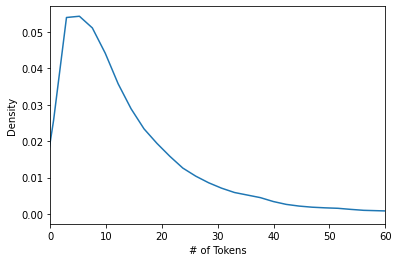

In [9]:
## Visualize token_lens with either of following plots
# token_lens.value_counts().sort_index().plot.line()
# token_lens.plot.hist(bins=200)
token_lens.plot.density()
plt.xlabel('# of Tokens')
plt.xlim(left=0, right=60)

In [10]:
# pick MAX LENGTH 
MAX_LENGTH = 30 # 90th percentile (smaller for faster training)

## Preprocess data

In [11]:
# Initialize data hyperparams
MAIN_CHARACTERS = ['ross', 'rachel', 'monica', 'phoebe', 'chandler', 'phoebe']
OTHER_CHARS = 'other_char'
CONTEXTS = [1, 3]

In [12]:
data_df.sample(5)

,episode,title,character,dialogue
17587,219,The One Where Eddie Won't Go,joey,"[he, paid, a, lot, of, money, for, it, .]"
23517,311,The One Where Chandler Can't Remember Which Si...,mr. kaplan,"[i, ’, ll, bet, your, thinking, ,, ‘, what, ’,..."
25864,315,The One Where Ross and Rachel Take A Break,chandler,"[yeah, ,, i-i-i, think, so, ., yeah, ,, i-i, t..."
75819,1018,The Last One (2),rachel,"[yeah, ,, okay, .]"
43974,611,The One With The Apothecary Table,rachel,"[guess, !]"


In [13]:
# filter characters to replace any non-main characters to OTHER
def keep_only_main(character):
    # split if contains multiple characters
    characters = character.split(',')
    for i, char in enumerate(characters):
        if char not in MAIN_CHARACTERS: characters[i] = OTHER_CHARS
    return ','.join(characters)

data_df.loc[:, 'character'] = data_df.character.progress_apply(keep_only_main)
data_df.sample(5)

100%|██████████| 76114/76114 [00:00<00:00, 839641.82it/s]


,episode,title,character,dialogue
68061,921,The One With The Fertility Test,other_char,"[and, first, ,, i, have, to, see, the, met, !]"
44455,613,The One With Rachel's Sister,other_char,"[ohh, !]"
29346,401,The One With The Jellyfish,chandler,"[well, ,, can, we, help, ?, !, you, want, us, ..."
59297,823,The One Where Rachel Has A Baby,other_char,"[hi, ., is, this, your, first, ?]"
48900,705,The One With The Engagement Picture,chandler,"[all, right, ,, but, i, should, warn, you, ,, ..."


In [14]:
# get contexts for samples (context only has previous messages separated by SEP token)
def get_contexts(row):
    row_idx = row.name
    episode = row.episode
    context_dialogues = []
    for ctx in CONTEXTS:
#         print("context", ctx, f'| range: {(row_idx-ctx, row_idx)}', list(range(row_idx-ctx, row_idx, -1)))
        diags = []
        for ctx_idx in range(row_idx-ctx, row_idx, 1):
#             print(ctx_idx, ctx_idx < 0)
            if ctx_idx < 0: continue
            diag_row = data_df.iloc[ctx_idx]
#             print(diag_row.episode, diag_row.episode != episode)
            if diag_row.episode != episode: continue
#             print((diag_row.filt_char, diag_row.diag_tok))
#             diags.append((diag_row.filt_char, diag_row.diag_tok))
            diags += diag_row.dialogue + ['SEP']
        # remove last 'SEP' added
        if len(diags) > 0: diags = diags[:-1]
        context_dialogues.append(diags if len(diags) != 0 else None)
    return pd.Series(context_dialogues, index=[f'ctx_{c}' for c in CONTEXTS])

data_df[[f'ctx_{c}' for c in CONTEXTS]] = data_df.progress_apply(get_contexts, axis=1)

100%|██████████| 76114/76114 [00:35<00:00, 2122.25it/s]


In [15]:
# check contexts
data_df.iloc[303:308]

,episode,title,character,dialogue,ctx_1,ctx_3
303,101,The Pilot-The Uncut Version,rachel,"[ugh, ., excuse, me, ,, could, you, give, this...","[ahh, ,, miss, ?, more, coffee, ?]","[yeah, ., yeah, ,, i, 'll, have, a, cup, of, c..."
304,101,The Pilot-The Uncut Version,chandler,"[okay, ,, so, ,, i, 'm, in, las, vegas, ..., i...","[ugh, ., excuse, me, ,, could, you, give, this...","[kids, ,, new, dream, ..., i, 'm, in, las, veg..."
305,102,The One With The Sonogram At the End,monica,"[what, you, guys, do, n't, understand, is, ,, ...",None,None
306,102,The One With The Sonogram At the End,other_char,"[yeah, ,, right, !, ......., y'serious, ?]","[what, you, guys, do, n't, understand, is, ,, ...","[what, you, guys, do, n't, understand, is, ,, ..."
307,102,The One With The Sonogram At the End,phoebe,"[oh, ,, yeah, !]","[yeah, ,, right, !, ......., y'serious, ?]","[what, you, guys, do, n't, understand, is, ,, ..."


In [16]:
# remove rows with no previous messages (ctx_1 is None)
data_df = data_df[~data_df.ctx_1.isna()]
data_df.shape

(75854, 6)

In [17]:
# split rows with multiple characters into individual rows
print("previously", data_df.shape)
cols = data_df.columns.tolist()
data = []
for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    thisrow = row.copy()
    chars = thisrow.character.split(',')
    for c in chars:
        thisrow.character = c
        data.append(thisrow.tolist())

data_df = pd.DataFrame(data, columns=cols)
print('after', data_df.shape)

previously (75854, 6)


100%|██████████| 75854/75854 [00:06<00:00, 11742.91it/s]

after (76209, 6)


In [18]:
# remove rows where dialogue is empty []
def isEmpty(dialogue):
    if len(dialogue) == 0:
        return True
    return False
diags = data_df.dialogue.progress_apply(isEmpty)
# rewrite data_df and don't include where diags was true
data_df = data_df[~diags]
data_df = data_df.reset_index(drop=True)
data_df

100%|██████████| 76209/76209 [00:00<00:00, 904747.62it/s]


,episode,title,character,dialogue,ctx_1,ctx_3
0,101,The Pilot-The Uncut Version,other_char,"[c'mon, ,, you, 're, going, out, with, the, gu...","[there, 's, nothing, to, tell, !, he, 's, just...","[there, 's, nothing, to, tell, !, he, 's, just..."
1,101,The Pilot-The Uncut Version,chandler,"[all, right, joey, ,, be, nice, ., so, does, h...","[c'mon, ,, you, 're, going, out, with, the, gu...","[there, 's, nothing, to, tell, !, he, 's, just..."
2,101,The Pilot-The Uncut Version,phoebe,"[wait, ,, does, he, eat, chalk, ?]","[all, right, joey, ,, be, nice, ., so, does, h...","[there, 's, nothing, to, tell, !, he, 's, just..."
3,101,The Pilot-The Uncut Version,phoebe,"[just, ,, 'cause, ,, i, do, n't, want, her, to...","[wait, ,, does, he, eat, chalk, ?]","[c'mon, ,, you, 're, going, out, with, the, gu..."
4,101,The Pilot-The Uncut Version,monica,"[okay, ,, everybody, relax, ., this, is, not, ...","[just, ,, 'cause, ,, i, do, n't, want, her, to...","[all, right, joey, ,, be, nice, ., so, does, h..."
...,...,...,...,...,...,...
76162,The,Stuff You've Never Seen,other_char,"[i, ’, m, sorry, ,, i, messed, up, .]","[i, think, you, got, it, !]","[oh, what, are, doing, ?, !, SEP, you, ’, re, ..."
76163,The,Stuff You've Never Seen,other_char,"[i, ’, ll, do, it, again, and, again, if, you,...","[i, ’, m, sorry, ,, i, messed, up, .]","[you, ’, re, still, a, tiny, bit, on, fire, th..."
76164,The,Stuff You've Never Seen,ross,"[no-no, !, i, ’, ll-i, ’, ll…]","[i, ’, ll, do, it, again, and, again, if, you,...","[i, think, you, got, it, !, SEP, i, ’, m, sorr..."
76165,The,Stuff You've Never Seen,other_char,"[that, is, too, much, !]","[no-no, !, i, ’, ll-i, ’, ll…]","[i, ’, m, sorry, ,, i, messed, up, ., SEP, i, ..."


## Choose two characters

We will choose two characters' dialogues to learn a chatbot with. With the same Seq2Seq with Attention architecture from HW5, we will try to associate characters' persona by using embeddings of their persona as first input to the decoder instead of the SOS_token used previously. 

In [19]:
# view character and dialogue counts
data_df.character.value_counts()

other_char    22620
ross          11590
rachel        11522
monica        10732
chandler      10448
phoebe         9255
Name: character, dtype: int64

In [20]:
CHOSEN_CHARACTERS = {"rachel", "phoebe"} # which characters to build chatbot for
print(data_df)

      episode                        title   character  \
0         101  The Pilot-The Uncut Version  other_char   
1         101  The Pilot-The Uncut Version    chandler   
2         101  The Pilot-The Uncut Version      phoebe   
3         101  The Pilot-The Uncut Version      phoebe   
4         101  The Pilot-The Uncut Version      monica   
...       ...                          ...         ...   
76162     The      Stuff You've Never Seen  other_char   
76163     The      Stuff You've Never Seen  other_char   
76164     The      Stuff You've Never Seen        ross   
76165     The      Stuff You've Never Seen  other_char   
76166     The      Stuff You've Never Seen  other_char   

                                                dialogue  \
0      [c'mon, ,, you, 're, going, out, with, the, gu...   
1      [all, right, joey, ,, be, nice, ., so, does, h...   
2                     [wait, ,, does, he, eat, chalk, ?]   
3      [just, ,, 'cause, ,, i, do, n't, want, her, to...   
4  

In [21]:
filtered_df = data_df[data_df.character.isin(CHOSEN_CHARACTERS)].reset_index(drop=True)
filtered_df

,episode,title,character,dialogue,ctx_1,ctx_3
0,101,The Pilot-The Uncut Version,phoebe,"[wait, ,, does, he, eat, chalk, ?]","[all, right, joey, ,, be, nice, ., so, does, h...","[there, 's, nothing, to, tell, !, he, 's, just..."
1,101,The Pilot-The Uncut Version,phoebe,"[just, ,, 'cause, ,, i, do, n't, want, her, to...","[wait, ,, does, he, eat, chalk, ?]","[c'mon, ,, you, 're, going, out, with, the, gu..."
2,101,The Pilot-The Uncut Version,phoebe,"[no, .]","[never, had, that, dream, .]","[instead, of, ..., ?, SEP, that, 's, right, .,..."
3,101,The Pilot-The Uncut Version,phoebe,"[ooh, !, oh, !]","[thanks, .]","[ohh, ., SEP, let, me, get, you, some, coffee,..."
4,101,The Pilot-The Uncut Version,phoebe,"[fine, !, be, murky, !]","[no, ,, no, do, n't, !, stop, cleansing, my, a...","[thanks, ., SEP, ooh, !, oh, !, SEP, no, ,, no..."
...,...,...,...,...,...,...
20772,The,Stuff You've Never Seen,phoebe,"[what, do, i, smell, ?]","[and, then, it, was, like, four, takes, later,...","[what, do, i, smell, ?, SEP, sorry, ., SEP, an..."
20773,The,Stuff You've Never Seen,phoebe,"[what, do, i, smell, ?]","[le, blanc, .]","[and, then, it, was, like, four, takes, later,..."
20774,The,Stuff You've Never Seen,phoebe,"[oh, ,, sweet, je——sus, !, oh, !, monica, ,, t...","[you, see, ,, i, don, ’, t, say—]","[you-you, mentally, make, a, flag, on, it, and..."
20775,The,Stuff You've Never Seen,rachel,"[i, ’, m, sorry…]","[joey, ?]","[whoa, !, she, ’, s, purty, !, SEP, oh, yeah, ..."


### Implement

We will now create create train / val splits. Please go to **`dataset.py`** and finish implementation for the function **`split_train_val`**. Make sure to also implement *shuffle* functionality if `shuffle=True`.

In [22]:
train_df, val_df = split_train_val(filtered_df, props=[0.85, 0.15], shuffle=True)
# view train val size
print(train_df.shape, val_df.shape)
# verify implementation
#assert train_df.shape[0] == 17660, "split is not implemented properly"
#assert val_df.shape[0] == 3117, "split is not implemented properly"

(17660, 6) (3117, 6)


Initialize vocabulary for input and target language vocabulary from train_df using the `initLang` function in `dataset.py`. This is already implemented for you. We will start with context size **1** (column = 'ctx_1')

In [23]:
context_column = 'ctx_1'
target_column = 'dialogue'
lang = initLang(characters=CHOSEN_CHARACTERS, df = train_df[[target_column, context_column]])

characters added | total_vocab_size: 5
initializing: dialogue | total_vocab_size: 9101
initializing: ctx_1 | total_vocab_size: 13029


In [24]:
lang.trim(2, keep=CHOSEN_CHARACTERS)

keep_words 7760 / 13029 = 0.5956


In [25]:
# make sure chosen characters are still in the vocabulary
[char in lang.word2index for char in CHOSEN_CHARACTERS]

[True, True]

### Implement

Create dataloaders for train, val and test data using `lang` variable defined above. Please go to `dataset.py` and finish the implementation for `Chatbot_Dataset.__getitem__()` in 

In [26]:
train_dataloader = create_data_loader(df = train_df, 
                                      lang = lang,
                                      context_col = context_column,
                                      target_col = target_column,
                                      MAX_LEN = MAX_LENGTH,
                                      shuffle=True)

val_dataloader = create_data_loader(df = val_df, 
                                      lang = lang,
                                      context_col = context_column,
                                      target_col = target_column,
                                      MAX_LEN = MAX_LENGTH,
                                      shuffle=True)

In [27]:
# view sample from dataloader
sample = next(iter(train_dataloader))
print('input_tensor', sample['input_tensor'], sample['input_tensor'].shape)
print('persona_tensor', sample['persona_tensor'], sample['persona_tensor'].shape)
print('target_tensor', sample['target_tensor'], sample['target_tensor'].shape)

input_tensor tensor([[ 274,    6,   14,  121,   28,    8,  262,  113,   75, 6770,   28,    1]]) torch.Size([1, 12])
persona_tensor tensor([[3]]) torch.Size([1, 1])
target_tensor tensor([[487,  28, 487,   6, 487,  28,   1]]) torch.Size([1, 7])


# Model Seq2Seq with Attention

Here, we reuse the simple encoder-decoder from last homework. Both encoder and decoders are RNNs (Gated Recurrent Units (GRU)). In the following section, you will implement `EncoderRNN` and `AttnDecoderRNN`. The encoder process previous context messages and provides it's outputs at every time step and last hidden state to the decoder. The decoder's first input with the a character's persona as well as outputs/hidden state from the encoder. 

**Relevant work**:
- [Sequence to Sequence Learnign with Neural Networks](https://arxiv.org/pdf/1409.3215.pdf)
- [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation]

### EncoderRNN and AttnDecoderRNN

Please **implement** the `__init__` and `__forward__` functions of the `EncoderRNN` and `AttnDecoderRNN` in `model.py`

In [28]:
# Helper functions used to keep track of time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Training the Seq2Seq with Attention

Please **implement** the following `train` function which process just one sample. The train loop is implemented for you after this cell. The template initializes relevant variables. You will implement for loops to step through encoder with `input_tensor` and decoder loop to step through `target_tensor` (with **and** without teacher forcing). The decoder loop is where you will also calculate the loss using the criterion. 

If you are unsure what arguments are being passed to the `train` function, please view the `train_iters` and `eval_iters` functions in the cells after. 

In [29]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, persona_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # initialize encoder hidden state
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size()[0]
    target_length = target_tensor.size()[0]
    loss = 0
    
    # this time we need to keep trak of encoder outputs
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    # Process input input_tensor (one token at a time with a for loop)
    ## YOUR CODE STARTS HERE (~3 lines of code) ##
    # for loop header
    for ei in range(input_length):
        # call encoder with input_tensor[ei] and encoder's hidden vector
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # save encoder output in encoder_outputs
        encoder_outputs[ei] = encoder_output[0, 0]

    ## YOUR CODE ENDS HERE ##

    # Start decoder's input with character (persona) token
    decoder_input = persona_tensor

    # initialize decoder hidden state as encoder's final hidden state
    decoder_hidden = encoder_hidden

    # decide whether to use teacher forcing 
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        ## YOUR CODE STARTS HERE (~4 lines of code) ##
        # for loop header to loop through target_tensor
        for di in range(target_length):
            # call decoder with decoder_input, decoder_hidden and encoder_outputs. 
            #     make sure to reset decoder_hidden with the new hidden state returned
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # calculate loss using decoder's output and corresponding target_tensor[di]
            #     the criterion used is a negative log likelihood loss (NLLLoss)
            loss += criterion(decoder_output, target_tensor[di])

            # (Teacher forcing) set next decoder input as target_tensor[di]
            decoder_input = target_tensor[di] 
        ## YOUR CODE ENDS HERE ##

    else:
        # Without teacher forcing: use its own predictions as the next input
        ## YOUR CODE STARTS HERE (~5-7 lines of code) ##
        # for loop header to loop through target_tensor
        for di in range(target_length):
            
            # call decoder same as above
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            # calculate loss same as above
            loss += criterion(decoder_output, target_tensor[di])
            # set next decoder input as argmax of decoder's output

            # if new decoder_input is EOS_token: break
            if decoder_input.item() == EOS_token:
                break

        ## YOUR CODE ENDS HERE ##

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Next, please **implement** the `evaluate` function in the next cell. The process will be the same as `train`, except you will not use teacher forcing when stepping through the decoder. 

In [30]:
# evaluate
def evaluate(input_tensor, target_tensor, persona_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]
        if target_tensor is not None:
            target_length = target_tensor.size()[0]
        else:
            target_length = max_length
        encoder_hidden = encoder.initHidden()
        loss = 0
        
        # this time we need to keep trak of encoder outputs
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        # Process input input_tensor (one token at a time with a for loop)
        ## YOUR CODE STARTS HERE (~3 lines of code) ##
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        ## YOUR CODE ENDS HERE ##

        # Start decoder's input with <SOS> token
        decoder_input = persona_tensor

        # initialize decoder hidden state as encoder's final hidden state
        decoder_hidden = encoder_hidden

        decoded_indices = []
        decoded_words = []
        # keep track of decoder attention for analysis later
        decoder_attentions = torch.zeros(max_length, max_length)

        # Run decoder starting with encoder's context (decoder_hidden)
        #     without using teacher forcing: use its own predictions as the next input
        ## YOUR CODE STARTS HERE (~5-7 lines of code) ##
        # for loop header to loop through target_tensor
        for di in range(target_length):
            # call decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # save decoder attention in decoder_attentions
            decoder_attentions[di] = decoder_attention.data

            # calculate loss same as above (if target_tensor exists)
            loss += criterion(decoder_output, target_tensor[di])


            # set next decoder input as argmax of decoder's output
            topv, topi = decoder_output.data.topk(1)
            decoder_input = topi.squeeze().detach()

            # append outputted index to decoded_indices

            # if new decoder_input is EOS_token: break
            if topi.item() == EOS_token:
                decoded_indices.append(EOS_token)
                break
            else:
                decoded_indices.append(topi.item())
        ## YOUR CODE ENDS HERE ##
        decoded_words = lang.getWordsFromIndices(decoded_indices)

        return decoded_words, int(loss) / len(decoded_words), decoder_attentions[:di + 1]

def generate(input_tensor, target_tensor, persona_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]
        if target_tensor is not None:
            target_length = target_tensor.size()[0]
        else:
            target_length = max_length
        encoder_hidden = encoder.initHidden()
        loss = 0
        
        # this time we need to keep trak of encoder outputs
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        # Process input input_tensor (one token at a time with a for loop)
        ## YOUR CODE STARTS HERE (~3 lines of code) ##
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        ## YOUR CODE ENDS HERE ##

        # Start decoder's input with <SOS> token
        decoder_input = persona_tensor

        # initialize decoder hidden state as encoder's final hidden state
        decoder_hidden = encoder_hidden

        decoded_indices = []
        decoded_words = []
        # keep track of decoder attention for analysis later
        decoder_attentions = torch.zeros(max_length, max_length)

        # Run decoder starting with encoder's context (decoder_hidden)
        #     without using teacher forcing: use its own predictions as the next input
        ## YOUR CODE STARTS HERE (~5-7 lines of code) ##
        # for loop header to loop through target_tensor
        for di in range(target_length):
            # call decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            # save decoder attention in decoder_attentions
            decoder_attentions[di] = decoder_attention.data

            # calculate loss same as above (if target_tensor exists)
            # loss += criterion(decoder_output, target_tensor[di])


            # set next decoder input as argmax of decoder's output
            topv, topi = decoder_output.data.topk(1)
            decoder_input = topi.squeeze().detach()

            # append outputted index to decoded_indices

            # if new decoder_input is EOS_token: break
            if topi.item() == EOS_token:
                decoded_indices.append(EOS_token)
                break
            else:
                decoded_indices.append(topi.item())
        ## YOUR CODE ENDS HERE ##
        decoded_words = lang.getWordsFromIndices(decoded_indices)

        return decoded_words#, int(loss) / len(decoded_words), decoder_attentions[:di + 1]


`trainEvalIters` is implemented for you. Simply review the implementation and run the following cells.

In [31]:
def createDataFrame(points):
    df = pd.DataFrame(points, columns=['train_loss', 'val_loss', 'blue_scores_val'])
    return df

def evalIters(encoder, decoder, val_dataloader, criterion, num_samples=100):
    if num_samples > len(val_dataloader):
        num_samples = len(val_dataloader)
    
    candidates = [] # predicted output
    references = [] # true targets
    
    total_loss = 0
    for iter, sample in enumerate(val_dataloader):
        if iter > num_samples: break

#         print("Eval Sample:", sample)
        input_tensor = sample['input_tensor'].squeeze().to(device)
        target_tensor = sample['target_tensor'].squeeze().to(device)
        persona_tensor = sample['persona_tensor'].squeeze().to(device)
        
        decoded_out, loss, _ = evaluate(input_tensor, target_tensor, persona_tensor, encoder, decoder, criterion)
#         print("Loss:", loss)
        candidates.append(decoded_out)
        target_indices = sample['target_tensor'].squeeze().tolist()
        target_words = lang.getWordsFromIndices(target_indices)
#         print(">", lang.getWordsFromIndices(sample['input_tensor'].squeeze().tolist()))
#         print("=", target_words)
#         print("<", decoded_out)
        references.append([target_words])
        total_loss += loss
    
    return total_loss / num_samples, bleu_score(candidate_corpus=candidates, 
                                                references_corpus=references,
                                                max_n=4)

def trainEvalIters(encoder, decoder, epochs, train_dataloader, val_dataloader, 
                   eval_every=1000, eval_samples=100, learning_rate=0.01):
    start = time.time()
    plot_stats = []
    train_loss_total = 0  # Reset every eval_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()
    num_samples = len(train_dataloader)
    n_iters = epochs * num_samples
    
    for ep in range(epochs):
        for iter, sample in enumerate(train_dataloader):
#             print("Train Sample:", sample)
            input_tensor = sample['input_tensor'].squeeze().to(device)
#             print(input_tensor.shape)
            target_tensor = sample['target_tensor'].squeeze().to(device)
            persona_tensor = sample['persona_tensor'].squeeze().to(device)

            loss = train(input_tensor, target_tensor, persona_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            train_loss_total += loss
#             print("loss:", loss)

            if (iter + 1) % eval_every == 0:
                train_loss_average = train_loss_total / eval_every
                train_loss_total = 0
                
                # validate model
                eval_loss, bleu_score = evalIters(encoder, decoder, val_dataloader, criterion, num_samples=eval_samples)
                
                curr_iter = ep * num_samples + iter + 1
                print('%s (%d %d%%) Average train loss: %.4f, Average val loss: %.4f ,val BLEU: %.4f' % (timeSince(start, curr_iter / n_iters), curr_iter, curr_iter / n_iters * 100, train_loss_average, eval_loss, bleu_score))

#                 plot_loss_avg = plot_loss_total / plot_every
                plot_stats.append([train_loss_average, eval_loss, bleu_score])
                plot_loss_total = 0

    return createDataFrame(plot_stats)

In [32]:
hidden_size = 512
n_layers = 1
lr = 0.005

encoder1 = EncoderRNN(lang.n_words, hidden_size, n_layers=n_layers).to(device)
decoder1 = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1, n_layers=n_layers, max_length=MAX_LENGTH).to(device)

epochs = 6

losses_df = trainEvalIters(encoder1, decoder1, epochs, train_dataloader, val_dataloader, eval_every=1000, eval_samples=200, learning_rate=lr)

1m 51s (- 194m 26s) (1000 0%) Average train loss: 4.2950, Average val loss: 4.9263 ,val BLEU: 0.0000
3m 38s (- 189m 14s) (2000 1%) Average train loss: 3.8489, Average val loss: 5.4975 ,val BLEU: 0.0000
5m 23s (- 184m 56s) (3000 2%) Average train loss: 3.7215, Average val loss: 5.1738 ,val BLEU: 0.0000
7m 2s (- 179m 30s) (4000 3%) Average train loss: 3.6289, Average val loss: 4.9676 ,val BLEU: 0.0000
8m 41s (- 175m 38s) (5000 4%) Average train loss: 3.4832, Average val loss: 4.5675 ,val BLEU: 0.0000
10m 26s (- 173m 52s) (6000 5%) Average train loss: 3.5785, Average val loss: 5.1211 ,val BLEU: 0.0000
12m 9s (- 171m 46s) (7000 6%) Average train loss: 3.3034, Average val loss: 4.4870 ,val BLEU: 0.0000
13m 49s (- 169m 20s) (8000 7%) Average train loss: 3.2997, Average val loss: 4.4073 ,val BLEU: 0.0000
15m 32s (- 167m 30s) (9000 8%) Average train loss: 3.3246, Average val loss: 4.5015 ,val BLEU: 0.0000
17m 16s (- 165m 42s) (10000 9%) Average train loss: 3.3483, Average val loss: 4.4915 ,val

<AxesSubplot:>

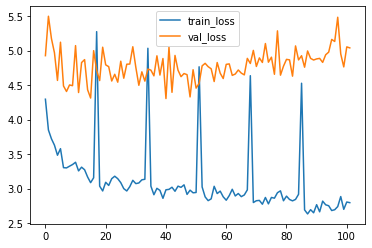

In [33]:
# Plot losses
losses_df.iloc[:, :-1].plot.line()

<AxesSubplot:>

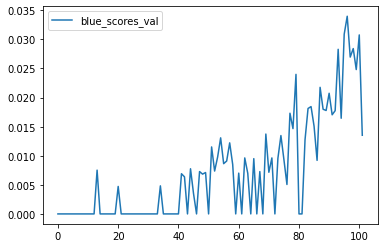

In [34]:
losses_df.iloc[:, -1:].plot.line()

### Chat with a character

Here is a quick function to manually assess the quality of your translator

In [35]:
def evaluateRandomly(encoder, decoder, val_dataloader, criterion, n=10):
    for i, sample in enumerate(val_dataloader):
        if i > n: break
        input_tensor = sample['input_tensor'].squeeze()
        target_tensor = sample['target_tensor'].squeeze()
        persona_tensor = sample['persona_tensor'].squeeze()
        
        print('>', ' '.join(lang.getWordsFromIndices(input_tensor.tolist())))
        print('=', ' '.join(lang.getWordsFromIndices(target_tensor.tolist())))
        
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        persona_tensor = persona_tensor.to(device)
        decoded_out, _ , _ = evaluate(input_tensor, target_tensor, persona_tensor, encoder, decoder, criterion)
        
        output_sentence = ' '.join(decoded_out)
        print('<', output_sentence)
        print('')
        
criterion = nn.NLLLoss()
evaluateRandomly(encoder1, decoder1, val_dataloader, criterion)

> . i did my impression of joan UNK as one of the UNK UNK ... `` can we walk '' ? oh , you ... you like that ? EOS
= no . EOS
< yeah , EOS

> oh no ! EOS
= what ? what is it ? EOS
< what ? EOS

> how can you come here ? EOS
= how could you not tell me you worked here ? EOS
< i know , i know , i know . . .

> oh , yeah , yeah , yeah ... EOS
= `` hi joey , it 's jane UNK ca n't wait for your party tonight '' EOS
< oh , so , so , so . EOS

> what ? why not ? rach , who can you not get ? EOS
= oh ! ok. ok , you really wan na know who it is ? EOS
< i 'm i . . . . . . . . . . EOS

> no , you ca n't ! friends UNK up is a bad idea . EOS
= please , what about you and chandler ? EOS
< i 'm i the it ? the i ?

> hey ! EOS
= joey , do you have peanut butter on the back of your head ? EOS
< hey ! EOS

> you like someone . tell me who it is . who is it ? EOS
= no . EOS
< it ’ s

> oh , UNK ! UNK ! EOS
= yah ! she 's ... uhm ... not very good though ... EOS
< yeah , okay , okay . EOS

> yeah ! as lon

In [36]:
def evaluateManually(encoder, decoder):
    print("chat with", CHOSEN_CHARACTERS)
    print('ENTER to run, Q/q to quit')
    personas = [lang.getIndexFromWord(t) for t in CHOSEN_CHARACTERS]
    
    while True:
        inp = input("You > ")
        print("You >"+inp)
        if inp.lower() == 'q': break
        
        toks = inp.split()[:MAX_LENGTH-1]
        input_tensor = torch.tensor([lang.getIndexFromWord(t) for t in toks] + [EOS_token], dtype=torch.long, device=device)
        for per in personas:
            persona_tensor = torch.tensor(per, dtype=torch.long, device=device)
            decoded_out = generate(input_tensor, None, persona_tensor, encoder, decoder, None)
            print(f"{lang.getWordFromIndex(per)} < {' '.join(decoded_out)}")

evaluateManually(encoder1, decoder1)

chat with {'phoebe', 'rachel'}
ENTER to run, Q/q to quit
You >hello
phoebe < i ! EOS
rachel < i 'm going to get EOS
You >What are you gonna do?
phoebe < oh , ! ! EOS
rachel < yeah ? EOS
You >
phoebe < i ! EOS
rachel < green ? EOS
You >What is the meaning of life?
phoebe < yeah ? EOS
rachel < yeah ? EOS
You >
phoebe < i ! EOS
rachel < green ? EOS
You >Pizza
phoebe < yeah ! EOS
rachel < yeah ? EOS
You >
phoebe < i ! EOS
rachel < green ? EOS
You >yeah?
phoebe < yeah ! EOS
rachel < yeah ? EOS
You >my bad
phoebe < i , i ! a EOS
rachel < i 'm a waitress . EOS
You >
phoebe < i ! EOS
rachel < green ? EOS
You >are you a waitress?
phoebe < yeah , i ! ! EOS
rachel < yeah , i 'm not a waitress . EOS
You >
phoebe < i ! EOS
rachel < green , i 'm a waitress . EOS
You >That is funny
phoebe < hey , EOS
rachel < hey you guys , i have a really good idea . EOS
You >
phoebe < i ! EOS
rachel < green ? EOS
You >what idea?
phoebe < i 'm a waitress . EOS
rachel < i 'm not gon na be with this ? EOS
You >
phoebe

## Visualize Attention

In [37]:
import matplotlib.ticker as ticker
def showAttention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateRandomlyAndShowAttention(encoder, decoder, val_dataloader, criterion):
    sample = next(iter(val_dataloader))
    
    input_words = lang.getWordsFromIndices(sample['input_tensor'].squeeze().tolist())
    input_tensor = sample['input_tensor'].squeeze().to(device)
    target_tensor = sample['target_tensor'].squeeze().to(device)
    persona_tensor = sample['person_tensor'].squeeze().to(device)
    output_words, _, attention = evaluate(input_tensor, target_tensor, persona_tensor, encoder, decoder, criterion)
    print('input : ', ' '.join(input_words))
    print('predicted :', ' '.join(output_words))
    showAttention(input_words, output_words, attention)

criterion = nn.NLLLoss()
evaluateRandomlyAndShowAttention(encoder1, decoder1, val_dataloader, criterion)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.